During this lab, we will refresh the notions about Homomorphic Encryption seen in class and create a simple Logistic Regression classifier which exploit this kind of encryption for carrying private computations!

This lab is based on the tutorials that can be found on the [TenSEAL github project](https://github.com/OpenMined/TenSEAL/tree/main/tutorials).

# 00 - Homomorphic Encryption

Let's start with recalling the definition of ***Homomorphism***:

A homomorphism is a map between two algebraic structures of the same type (e.g. vector spaces), that preserves the operations of the structures. This means a map $f:\mathcal{A}\to \mathcal{B}$ between two sets $\mathcal{A}$, $\mathcal{B}$ equipped with the same structure such that, if $\star$ is an operation of the structure (supposed here, for simplification, to be a binary operation), then:
$$
f(A_1\star A_2) = f(A_1)\star f(A_2)\;\;\;\forall A_1,A_2\in\mathcal{A}
$$


Now, suppose that $f$ is an encryption map that transform a plaintext which contains sensitive information into a cyphertext capable of completely masking it. This kind of encryption could allow us to work on cyphertexts seamelessly as we would perform the required operations on the original plaintexts!

For example, lets consider the pseudo-code snippet below:
```
# ----- User has these private variables and a secet key
private_x = 453
private_y = 590
secr_key = 42

# ----- User encrypts the variables and send them to an untrusted server for computations
encr_x = HE.encrypt(private_x, secr_key)
encr_y = HE.encrypt(private_y, secr_key)
send_to_remote_server(encr_x, encr_y)

# ----- Server-side: compute the required operations and send the results back to the user
encr_x, encr_y = receive_from_user()
encr_res = encr_x + encr_y
send_to_user(encr_res)

# ----- User receive the results from server and check the correctness of the outsorced operations
encr_res = receive_from_remote_server()
decr_res = encr_sum.decrypt(secr_key)

plain_sum = private_x + private_y

plain_sum == decr_res
>>> prints True
```

Historically, Homomorphic Encryption (from now on, HE) can be divided in three families, depending on the oparations and the number of computations allowed:
* ***Partial HE*** benefits from an unlimited number of computations, but only
one operation is allowed (e.g. summation, multiplication);
* ***Somewhat HE*** allows for multiple operations but suffers from a limited number of computations due to an increasing amount of computations-derived noise;
* ***Full HE*** allows both a multiple number of operations and an unlimited number of computations, but generally suffers from huge computational costs.



In this tutorial we will exploit the python library for HE [TenSEAL](https://github.com/OpenMined/TenSEAL) curated by [OpenMined](https://www.openmined.org/).
TenSEAL is built on top of [Microsoft SEAL](https://github.com/Microsoft/SEAL), a C++ library implementing the BFV (for computations on integer number) and CKKS (on real numbers) homomorphic encryption schemes.

**Let's get started!**

# 01 - Getting Familiar with TenSeal

As always, install the library!

In [1]:
try:
    import tenseal as ts
except ImportError:
    %pip install tenseal
    import tenseal as ts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 13.6 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np

## 01a - TenSEAL Context

First, we need to instantiate a tenseal context, that is a special object that wrap all the encryption parameters for the selected scheme. In particulat, note how it holds both the secret and public encryption keys.

In [3]:
help(ts.Context)

Help on class Context in module tenseal.enc_context:

class Context(builtins.object)
 |  Context(scheme: tenseal.enc_context.SCHEME_TYPE = None, poly_modulus_degree: int = None, plain_modulus: int = None, coeff_mod_bit_sizes: List[int] = [], encryption_type: tenseal.enc_context.ENCRYPTION_TYPE = <ENCRYPTION_TYPE.ASYMMETRIC: <ENCRYPTION_TYPE.ASYMMETRIC: 0>>, n_threads: int = None, data: _tenseal_cpp.TenSEALContext = None)
 |  
 |  Methods defined here:
 |  
 |  __copy__(self) -> 'Context'
 |  
 |  __init__(self, scheme: tenseal.enc_context.SCHEME_TYPE = None, poly_modulus_degree: int = None, plain_modulus: int = None, coeff_mod_bit_sizes: List[int] = [], encryption_type: tenseal.enc_context.ENCRYPTION_TYPE = <ENCRYPTION_TYPE.ASYMMETRIC: <ENCRYPTION_TYPE.ASYMMETRIC: 0>>, n_threads: int = None, data: _tenseal_cpp.TenSEALContext = None)
 |      Construct a context that holds keys and parameters needed for operating
 |      encrypted tensors using either BFV or CKKS scheme.
 |      
 |     

In [4]:
context = ts.context(ts.SCHEME_TYPE.BFV, poly_modulus_degree=4096, plain_modulus=1032193)
context

## 01b - Encryption

Once we have defined a TenSEAL context and the relative public key, we can encrypt a vector (or a matrix) of numbers (integer or real depending on the exploited encryption scheme).

In [5]:
# define a plain vector and a matrix
plain_vct = [1,2,3,4]
plain_mtx = np.array([1,2,3,4,5,6]).reshape(2,-1)

In [6]:
# ----- encrypted vector
encr_vct = ts.bfv_vector(context, plain_vct)
encr_vct.size()

4

In [7]:
# ----- encrypted matrix
encr_mtx = ts.bfv_tensor(context, plain_mtx)
encr_mtx.shape

[2, 3]

## 02c - Evaluation

Let's start doing some encrypted computations!

In [8]:
# ----- Sum with plain vector
pl_add = encr_vct + plain_vct
pl_add.decrypt()

[2, 4, 6, 8]

In [9]:
# ----- Multiplication with plain vector
pl_mul = encr_vct * plain_vct
pl_mul.decrypt()

[1, 4, 9, 16]

In [10]:
# ----- Multiplication with encrypted vector
encr_mul = encr_vct * encr_vct
encr_mul.decrypt()

[1, 4, 9, 16]

In [11]:
# ----- matrix multiplication
encr_mm = encr_mtx.mm(plain_mtx.T)
encr_mm.decrypt().tolist()

[[14, 32], [32, 77]]

## 03c - Requirements

As seen in class, the major drawbacks of performing encrypted computation with HE is a big increase in the computational requirements, both in terms of time and memory! Let's try to measure the difference.

In the example below we will simulate the memory and time impact of performing a backpropagation round of a data matrix with 50 samples and 10 features.

In [12]:
def random_data(n=50, d=10):
    # data separable by the line `y = x`
    x = np.random.randn(n, d)
    y = (x[:, 0] >= x[:, 1]).astype(float)
    return x, y

In [13]:
# ----- Memory requirements
import sys

n = 100
d = 10
plain_mtx, plain_trg = random_data(n, d)
print(f"The memory impact of the plaintext matrix is {sys.getsizeof(plain_mtx)} bytes")

The memory impact of the plaintext matrix is 8128 bytes


In [14]:
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 20, 20, 40]
# create TenSEALContext
context = ts.context(ts.SCHEME_TYPE.CKKS,
                     poly_modulus_degree=poly_mod_degree,
                     coeff_mod_bit_sizes=coeff_mod_bit_sizes)
context.global_scale = 2**20
context.generate_galois_keys()

In [15]:
encr_mtx = ts.ckks_tensor(context, plain_mtx)
encr_trg = ts.ckks_tensor(context, plain_trg)

byt = sum([sys.getsizeof(c.data()) for c in encr_mtx.ciphertext()])
print(f"The memory impact of the cyphertext matrix is {byt} bytes")

The memory impact of the cyphertext matrix is 32000 bytes


We discovered that the requirements of simply loading this encrypted data to memory are around 4 times the original plain matrix.
This, of course, depend on the privacy strength that we want to guarantee for our data and algorithm: simpler algorithms or weaker privacy guarantees can work with smaller cyphertexts that will imply a smaller memory overhead.

Let's measure the time impact for performing a simple linear backpropagation round.

In [25]:
import time

class SquareError:
    @staticmethod
    def risk(pred_out, desired_out):
        return ((pred_out-desired_out)**2).sum()

    @staticmethod
    def delta(pred_out, desired_out):
        return pred_out-desired_out

class linearClassifier:
    def __init__(self, n_feat, rnd_seed=42):
        self.w = np.random.default_rng(rnd_seed).standard_normal(n_feat)

    def forward(self, x):
        res = x.dot(self.w)
        return res

    def backpropagate(self, x, y, loss_criterion, lr=1e-1):
        # predict
        pred = self.forward(x)
        # compute gradients
        loss_delta = loss_criterion.delta(pred,y)
        delta_w = x.transpose().dot(loss_delta)
        if isinstance(delta_w, ts.CKKSTensor):
            delta_w = np.array(delta_w.decrypt().tolist())
        # update weights
        self.w -= lr * delta_w

In [27]:
# backpropagation of plain data

lin_cl = linearClassifier(d)
loss = SquareError()
print(f"Pre-backpropagation loss: {loss.risk(lin_cl.forward(plain_mtx),plain_trg):.2f}")
t = time.time()
# perform backpropagatiion
lin_cl.backpropagate(plain_mtx, plain_trg, loss, lr=1e-2)
t = time.time() - t
print(f"Post-backpropagation loss: {loss.risk(lin_cl.forward(plain_mtx),plain_trg):.2f}")
print(f"\nBackpropagation on plaintext took {t:.2e}")

Pre-backpropagation loss: 1029.94
Post-backpropagation loss: 236.36

Backpropagation on plaintext took 2.09e-04


In [28]:
# backpropagation of encripted data

lin_cl = linearClassifier(d)
loss = SquareError()
print(f"Pre-backpropagation loss: {loss.risk(lin_cl.forward(encr_mtx),plain_trg).decrypt().tolist():.2f}")
t = time.time()
# perform backpropagatiion
lin_cl.backpropagate(plain_mtx, plain_trg, loss, lr=1e-2)
t = time.time() - t
print(f"Post-backpropagation loss: {loss.risk(lin_cl.forward(plain_mtx),plain_trg):.2f}")
print(f"\nBackpropagation on plaintext took {t:.2e}")

Pre-backpropagation loss: 1416.97
Post-backpropagation loss: 236.36

Backpropagation on plaintext took 1.71e-04


This simple linear example demonstrates that, even for a small number of samples, the overhead in computational time for the backpropagation is around 3-4 orders of magnitude!

If you want to learn more on the theory behind the CKKS encryption scheme, [check this blog post by OpenMined](https://blog.openmined.org/ckks-explained-part-1-simple-encoding-and-decoding/).

# 02 - Implementing a Logistic Regression classifier

Now we will try to implement a simple logistic regression classifier that is able to mask sensitive information thanks to the use of homomorphic encryption.

We will build our classifier so that it will mimic the functionalities of a pytorch module.

## 02a - The Dataset

But first we will download the data for our experiment: [Heart disease](https://www.kaggle.com/datasets/dileep070/heart-disease-prediction-using-logistic-regression?resource=download)

The dataset is publically available on the Kaggle website, and it is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts. The classification goal is to predict whether the patient has 10-year risk of future coronary heart disease (CHD).The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes. Since it contains the patients information, it serves well as a sensitive application where we should mask the data and guarantee patients' privacy.

In [30]:
!gdown 1b1cpGagEBnGSscdKK7G0CeyDrlQXUbem

Downloading...
From: https://drive.google.com/uc?id=1b1cpGagEBnGSscdKK7G0CeyDrlQXUbem
To: /content/framingham.csv
100% 196k/196k [00:00<00:00, 84.9MB/s]


In [31]:
import pandas as pd
import numpy as np

In [32]:
def split_train_test(x, y, test_ratio=0.3, num_samples=100):
    rng = np.random.default_rng(42)
    idxs = rng.choice(len(x), size=num_samples, replace=False)
    # delimiter between test and train data
    delim = int(len(idxs) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]

def heart_disease_data():
    data = pd.read_csv("./framingham.csv")
    # drop rows with missing values
    data = data.dropna()
    # drop some features
    data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])
    # balance data
    grouped = data.groupby('TenYearCHD')
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
    # extract labels
    y = np.array(data["TenYearCHD"].values, dtype=float)[:,None]
    data = data.drop(columns="TenYearCHD")
    # standardize data
    data = (data - data.mean()) / data.std()
    x = np.array(data.values, dtype=float)
    # reduce cardinality
    return split_train_test(x, y, test_ratio=0.3, num_samples=150)

In [40]:
x_train, y_train, x_test, y_test = heart_disease_data()

n_feat = x_train.shape[1]

print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")

x_train has shape: (105, 9)
y_train has shape: (105, 1)
x_test has shape: (45, 9)
y_test has shape: (45, 1)


## 02b - Defining and training a standard Logistic Regression classifier

First of all we need to define the logistic (Sigmoid) function for performing the classification task and the loss function for training our model

In [43]:
class Sigmoid:
    @staticmethod
    def forward(x):
        return 1/(1+np.e**(-x))

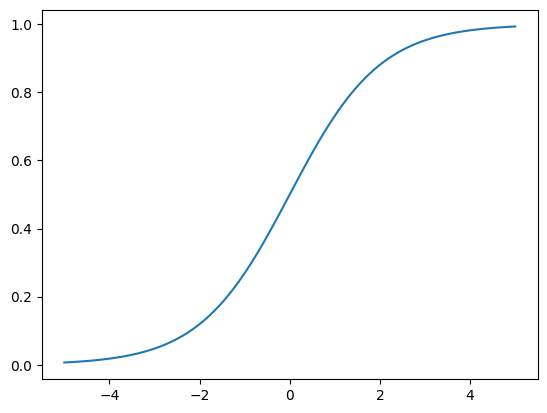

In [46]:
# observe sigmoid function
inputs = np.linspace(-5,5,100)
sigm_vals = Sigmoid.forward(inputs)
plt.plot(inputs, sigm_vals);

In [47]:
class BinaryCrossEntropyLoss:
    @staticmethod
    def forward(pred, true):
        return (true*np.log(pred) + (1-true)*np.log(1-pred)).mean()

    @staticmethod
    def delta(pred, true):
        return pred - true # cross-entropy + sigmoid trick

def sigmoidal_accuracy_score(pred, true):
    return round((np.abs(pred - true) < .5).astype(float).mean(), 2)

Now, we can define the class for our Logistic Regression classifier:

In [48]:
class LogisticRegression:
    def __init__(self, n_features, rnd_seed=42):
        rng = np.random.default_rng(rnd_seed)
        self.weights = rng.standard_normal((n_features,1))
        self.bias = np.array([0.])

        self._delta_w = 0
        self._delta_b = 0

    def forward(self, x):
        raw = x.dot(self.weigths) + self.bias
        log = Sigmoid.forward(raw)
        return log

    def predict(self, x):
        return (self.forward(x) > .5).astype(int)

    def reset_gradients(self):
        self._delta_w = 0
        self._delta_b = 0

    def train(self, tr_x, tr_y, vl_x, vl_y, loss, epochs=10, lr=1e-1):
        acc_tr = sigmoidal_accuracy_score(self.predict(tr_x), tr_y)
        acc_ts = sigmoidal_accuracy_score(self.predict(vl_x), vl_y)
        print(f"Train accuracy @ep 0 = {acc_tr}")
        print(f"Test accuracy @ep 0 = {acc_ts}")

        for ep in range(1,epochs+1):
            # reset gradients counters
            self.rest_gradients()

            # predict and update gradients
            pred = self.forward(tr_x)
            loss_delta = loss.delta(pred, tr_y)
            self._delta_w += tr_x.traspose().dot()
            self._delta_b += loss_delta.sum()

            # update parameters
            self.weights -= lr * self._delta_w
            self.bias -= lr * self._delta_b

            acc_tr = sigmoidal_accuracy_score(self.predict(tr_x), tr_y)
            acc_ts = sigmoidal_accuracy_score(self.predict(vl_x), vl_y)
            print(f"\nTrain accuracy @ep {ep} = {acc_tr}")
            print(f"Test accuracy @ep {ep} = {acc_ts}")

In [52]:
lrc = LogisticRegression(n_feat)
bce = BinaryCrossEntropyLoss()
lrc.train(x_train, y_train, x_test, y_test, bce, epochs=10, lr=1e-2)

AttributeError: ignored

With this particular configuration, the linear classifier is able to classify correctly almost 70% of the test samples, not bad!

## 02c - Evaluating a trained logistic regression classifier on encrypted data

Before trying to train a classifier on private data from scracth we need to fix some issues.

For example, remember how our encryption scheme for real number (CKKS) allows us to perform only addition and multiplcation? That means we can't use the very core structure of a Logistic regression classifier: the logistic function!

Luckily, the Sigmoid can be approximated by a polynomial of degree 3 that behaves sufficiently well in the range \[-3,3\] (remember that we have standardized our data!):
$$
sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
$$
\[from [Chen2018Logistic](https://eprint.iacr.org/2018/462.pdf)\].

In [53]:
class ApproximatedSigmoid:
    @staticmethod
    def forward(x):
        if isinstance(x, np.ndarray):
            return np.polyval([0.5, 0.197, 0, -0.004], x)
        return x.polyval([0.5, 0.197, 0, -0.004])

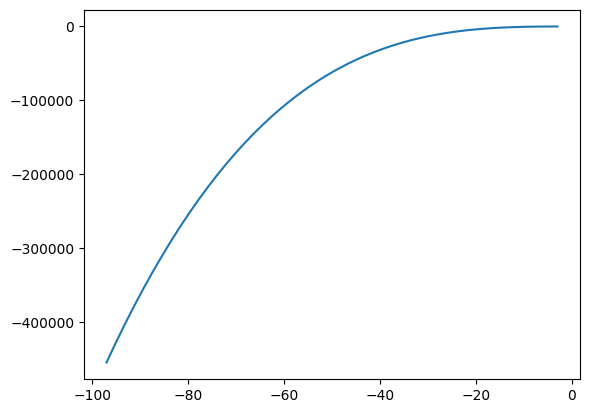

In [55]:
# observe the sigmoid approximation
inputs = np.linspace(-3,3-100)
sigm_vals = ApproximatedSigmoid.forward(inputs)
plt.plot(inputs, sigm_vals);

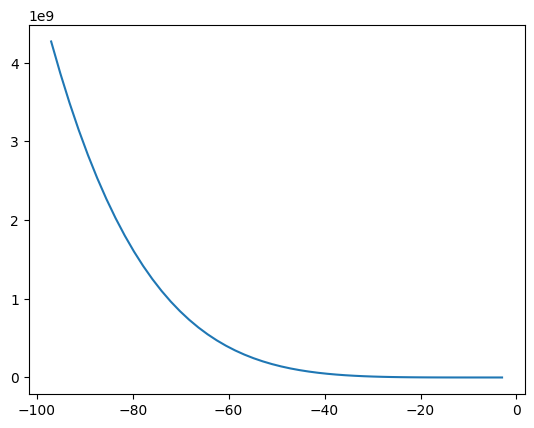

In [60]:
# observe the difference between the true sigmoid and the approximation

true_sigm = Sigmoid.forward(inputs)

plt.plot(inputs, np.abs(true_sigm - approx_mcl_sigm));

In [56]:
class MacLaurinSigmoid:
    @staticmethod
    def forward(x):
        if isinstance(x, np.ndarray):
            return np.polyval([1/2, 1/4, 0, -1/48, 0, 1/480], x)
        return x.polyval([1/2, 1/4, 0, -1/48, 0, 1/480])

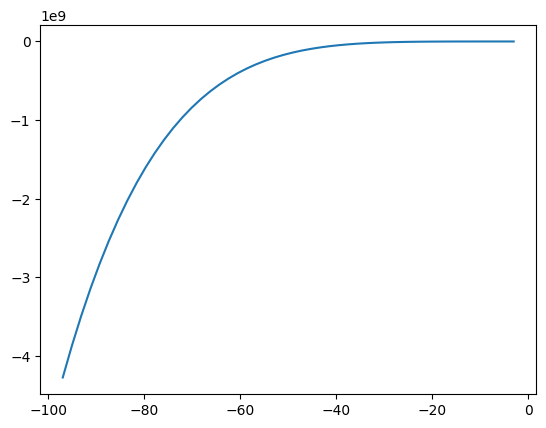

In [62]:
# observe the maclaurin approximation of the sigmoid
approx_mcl_sigm = MacLaurinSigmoid.forward(inputs)
plt.plot(inputs, approx_mcl_sigm);

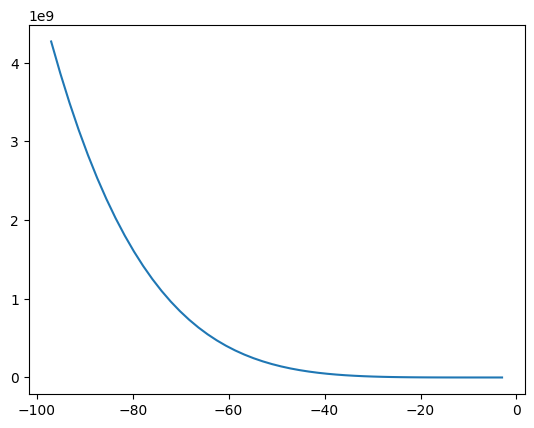

In [61]:
# observe the difference between the true sigmoid and the maclaurin approximation

plt.plot(inputs, np.abs(true_sigm - approx_mcl_sigm));

Before defining a Logistic regression classifier that is able to be trained on encrypted data, we can define one that is able to load the parameters from a trained model (on plaintexts) and just make predictions (on encrypted data).
This new model obviously will observe the constraints imposed by the encryption scheme and so it will exploit the polynomial approximation of the Sigmoid.

In [63]:
class EncryptedLogisticRegression:
    def __init__(self, trained_classifier):
        self.weights = trained_classifier.weights
        self.bias = trained_classifier.bias

    def forward(self, x):
        raw = x.dot(self.weights) + self.bias
        log = ApproximatedSigmoid.forward(raw)
        return log

In [65]:
elrc = EncryptedLogisticRegression(lrc)

In [66]:
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
context.global_scale = 2 ** 21
context.generate_galois_keys()

In [67]:
# ----- Encrypt private data
encr_x_train = ts.ckks_tensor(context, x_train)
encr_x_test = ts.ckks_tensor(context, x_test)

In [68]:
# ----- Forward encrypted data through the network
encr_pred_tr = elrc.forward(encr_x_train)
encr_pred_ts = elrc.forward(encr_x_test)

In [69]:
# ----- Decrypt and compute predictions
decr_pred_tr = np.array(encr_pred_tr.decrypt().tolist())
decr_pred_tr = (decr_pred_tr > .5).astype(int)
decr_pred_ts = np.array(encr_pred_ts.decrypt().tolist())
decr_pred_ts = (decr_pred_ts > .5).astype(int)

encr_tr_acc = sigmoidal_accuracy_score(decr_pred_tr, y_train)
encr_ts_acc = sigmoidal_accuracy_score(decr_pred_ts, y_test)
print(f"Encrypted train accuracy: {encr_tr_acc}")
print(f"Encrypted test accuracy: {encr_ts_acc}")

Encrypted train accuracy: 0.38
Encrypted test accuracy: 0.29


We observe that in this case the random noise added by the encryption scheme was not able to corrupt (or improve) the model average accuracy!

## 02d - Training a Logistic Regression classifier on private data

Now, we can extend the class defined above so that the classifier can be trained on encrypted data from scratch.

From the results above, we can see how the logistic regressor classifier can be trained on the encrypted data and achieve results comparable to the "plaintext" classifier despite the added encryption noise and computational overhead!

In [70]:
class EncryptedLR:
    def __init__(self, lr):
        self.weight = lr.weights.squeeze().tolist()
        self.bias = lr.bias.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out

    @staticmethod
    def sigmoid(enc_x):
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    def backward(self, enc_x, enc_out, enc_y):
        loss_delta = enc_out - enc_y
        self._delta_w += enc_x * loss_delta
        self._delta_b += loss_delta
        self._count += 1

    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update parameters
        self.weight -= (1 / self._count) * self._delta_w + self.weight * 0.05
        self.bias -= (1 / self._count) * self._delta_b
        # reset gradients
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def plain_accuracy(self, x_test, y_test):
        w = np.array(self.weight)
        b = np.array(self.bias)
        out = Sigmoid.forward(x_test.dot(w) + b).reshape(-1, 1)
        correct = np.abs(y_test - out) < 0.5
        return correct.astype(float).mean()

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def train(self,
              enc_x_tr, enc_y_tr,
              pln_x_tr, pln_y_tr,
              pln_x_ts, pln_y_ts,
              epochs=10):
        tr_accuracy = self.plain_accuracy(pln_x_tr, pln_y_tr)
        ts_accuracy = self.plain_accuracy(pln_x_ts, pln_y_ts)
        print(f"Train accuracy at epoch #0: {tr_accuracy:.2f}")
        print(f"Test accuracy at epoch #0: {ts_accuracy:.2f}")

        times = []
        for epoch in range(epochs):
            eelr.encrypt(ctx_training)

            t_start = time()
            for enc_x, enc_y in zip(enc_x_train, enc_y_train):
                enc_out = eelr.forward(enc_x)
                eelr.backward(enc_x, enc_out, enc_y)
            eelr.update_parameters()
            t_end = time()
            times.append(t_end - t_start)

            eelr.decrypt()
            tr_accuracy = eelr.plain_accuracy(pln_x_tr, pln_y_tr)
            ts_accuracy = eelr.plain_accuracy(pln_x_ts, pln_y_ts)
            print(f"\nTrain accuracy at epoch #{epoch + 1}: {tr_accuracy:.2f}")
            print(f"Test accuracy at epoch #{epoch + 1}: {ts_accuracy:.2f}")


        print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
        print(f"Final train accuracy: {tr_accuracy:.2f}")
        print(f"Final test accuracy: {ts_accuracy:.2f}")

In [72]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [73]:
from time import time

t_start = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 1 seconds


Distribution on plain data:


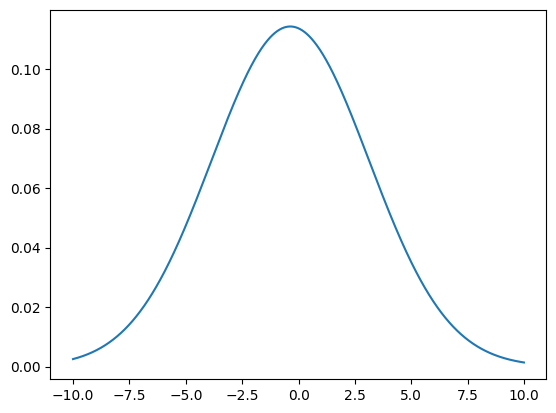

Distribution on encrypted data:


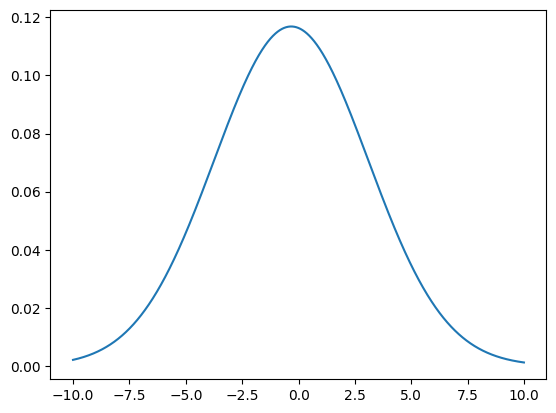

In [74]:
normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)

# plain distribution
n_features = x_train.shape[1]
lr = LogisticRegression(n_features)
data = x_test.dot(lr.weights) + lr.bias
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = np.array(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(lr)
eelr.encrypt(ctx_training)
encrypted_out_distribution(eelr, enc_x_train)

In [75]:
eelr = EncryptedLR(LogisticRegression(n_feat))
eelr.train(enc_x_train, enc_y_train,
           x_train, y_train,
           x_test, y_test)

Train accuracy at epoch #0: 0.34
Test accuracy at epoch #0: 0.29

Train accuracy at epoch #1: 0.56
Test accuracy at epoch #1: 0.42

Train accuracy at epoch #2: 0.72
Test accuracy at epoch #2: 0.56

Train accuracy at epoch #3: 0.71
Test accuracy at epoch #3: 0.47

Train accuracy at epoch #4: 0.70
Test accuracy at epoch #4: 0.53

Train accuracy at epoch #5: 0.69
Test accuracy at epoch #5: 0.53

Train accuracy at epoch #6: 0.70
Test accuracy at epoch #6: 0.51

Train accuracy at epoch #7: 0.70
Test accuracy at epoch #7: 0.56

Train accuracy at epoch #8: 0.70
Test accuracy at epoch #8: 0.56

Train accuracy at epoch #9: 0.71
Test accuracy at epoch #9: 0.56

Train accuracy at epoch #10: 0.70
Test accuracy at epoch #10: 0.53

Average time per epoch: 9 seconds
Final train accuracy: 0.70
Final test accuracy: 0.53
